Import Libraries

In [2]:
!pip install neuralforecast
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error
from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS
from neuralforecast.losses.pytorch import MSE

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 285.8/285.8 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.4/68.4 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

Data Prep

In [4]:
# Load and prepare dataset
df = pd.read_csv("temperature.csv", parse_dates=["datetime"])
# Convert datetime column using a more flexible parse due to format issues
df['datetime'] = pd.to_datetime(df['datetime'], format='mixed', dayfirst=False)
df.rename(columns={"id": "unique_id", "datetime": "ds", "temp": "y"}, inplace=True)
#drop all unneeded columns
df = df[['unique_id', 'ds', 'y']]
df['unique_id'] = 'sensor_1'
df = df.sort_values("ds").dropna()
# Sort by time
df = df.sort_values("ds")

<ipython-input-4-7f17659fb045>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['unique_id'] = 'sensor_1'


Feature Engineering

In [5]:
# Add time-based and statistical features
df['month'] = df['ds'].dt.month
df['hour'] = df['ds'].dt.hour
df['weekday'] = df['ds'].dt.weekday
df['temp_delta'] = df['y'].diff().fillna(0)
df['temp_roll_mean'] = df['y'].rolling(window=6, min_periods=1).mean()

Training

In [6]:
# Train/test split
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size][['unique_id', 'ds', 'y']]
test_df = df.iloc[train_size:][['unique_id', 'ds', 'y']]

In [7]:
# Train NHITS model
model = NHITS(h=24, input_size=24, loss=MSE(), max_steps=100)
nf = NeuralForecast(models=[model], freq='H')
nf.fit(df=train_df)

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MSE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.794     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.


Forecast

In [8]:
# Forecast
forecast_df = nf.predict()

/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:384: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:440: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Evaluation and Generative Modeling VAE

In [9]:
# Evaluation
y_pred = forecast_df['NHITS'].values
y_true = test_df['y'].values[:len(y_pred)]

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
print(f"MAE: {mae:.2f}, MSE: {mse:.2f}")
print(forecast_df.head())

# --- VAE for Data Augmentation ---
# Prepare data for VAE
sequence_length = 24
X = [df['y'].values[i:i + sequence_length] for i in range(len(df) - sequence_length)]
X = torch.tensor(X, dtype=torch.float32)

# Define VAE
class VAE(nn.Module):
    def __init__(self, input_dim=24, latent_dim=8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

# Train VAE
vae = VAE()
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
loader = DataLoader(TensorDataset(X), batch_size=32, shuffle=True)

for epoch in range(10):
    for batch in loader:
        x_batch = batch[0]
        x_recon = vae(x_batch)
        loss = loss_fn(x_recon, x_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Generate synthetic sequences
with torch.no_grad():
    z = torch.randn(100, 8)
    synthetic = vae.decoder(z).numpy()

print("Synthetic data shape:", synthetic.shape)

MAE: 0.53, MSE: 0.41
  unique_id                  ds      NHITS
0  sensor_1 2018-11-09 13:52:00  33.267159
1  sensor_1 2018-11-09 14:52:00  33.268593
2  sensor_1 2018-11-09 15:52:00  33.219536
3  sensor_1 2018-11-09 16:52:00  33.250832
4  sensor_1 2018-11-09 17:52:00  33.227757


<ipython-input-9-afaaac952cc5>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  X = torch.tensor(X, dtype=torch.float32)


Synthetic data shape: (100, 24)


Convert and Save to New File

In [10]:
# Convert to DataFrame
synthetic_df = pd.DataFrame(synthetic)
synthetic_df.columns = [f"step_{i}" for i in range(1, 25)]

# Optionally add an ID column
synthetic_df["unique_id"] = "synthetic"

In [11]:
synthetic_df.to_csv("synthetic_temperature_data.csv", index=False)
print("Saved to synthetic_temperature_data.csv")

Saved to synthetic_temperature_data.csv


Data Visualization- Compare Original with Synthetic

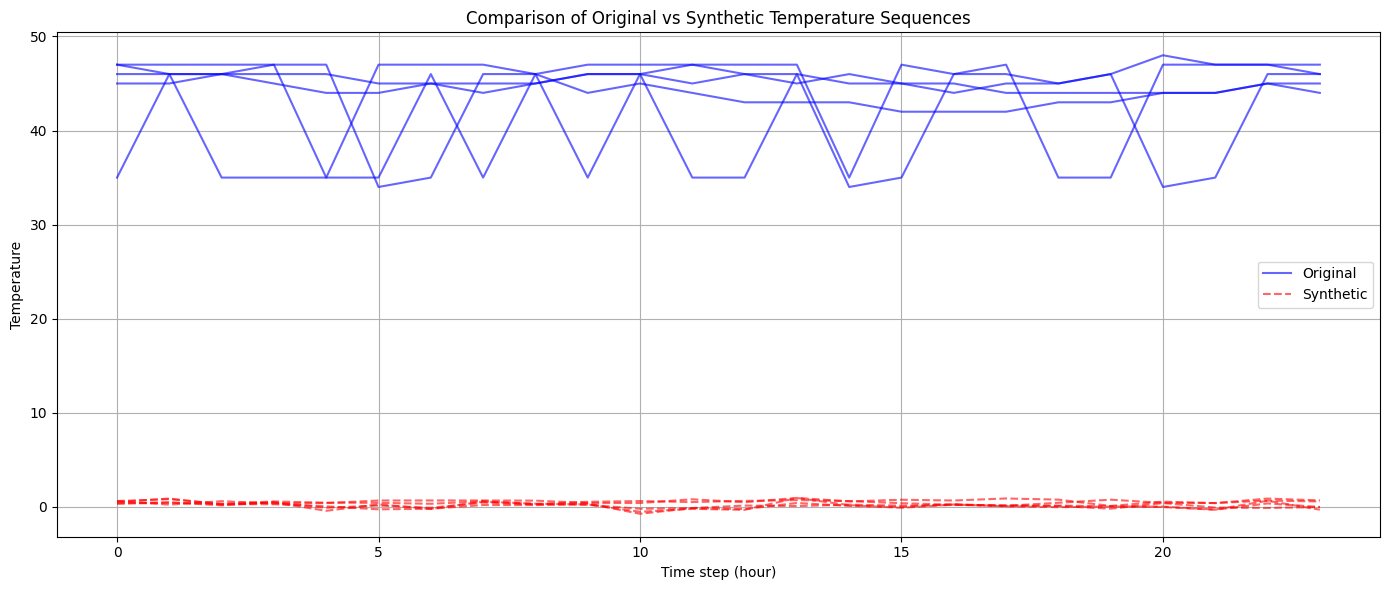

In [12]:
import matplotlib.pyplot as plt

# Plot original data (e.g., last 5 sequences of length 24)
plt.figure(figsize=(14, 6))

for i in range(5):
    start_idx = -((i + 1) * 24)
    end_idx = -(i * 24) if i > 0 else None
    plt.plot(range(24), df['y'].values[start_idx:end_idx], color='blue', alpha=0.6, label='Original' if i == 0 else "")

# Plot 5 synthetic sequences
for i in range(5):
    plt.plot(range(24), synthetic[i], color='red', alpha=0.6, linestyle='--', label='Synthetic' if i == 0 else "")

# Labels and legend
plt.title("Comparison of Original vs Synthetic Temperature Sequences")
plt.xlabel("Time step (hour)")
plt.ylabel("Temperature")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


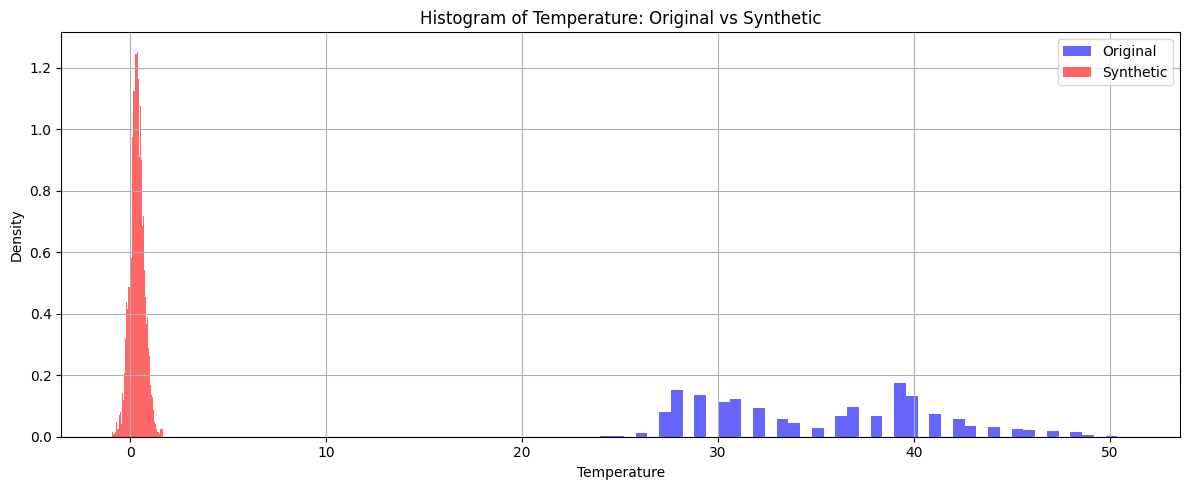

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Flatten synthetic data (100 sequences × 24 steps → 2400 values)
synthetic_flat = synthetic.flatten()

# Histogram
plt.figure(figsize=(12, 5))
plt.hist(df['y'], bins=50, alpha=0.6, label='Original', color='blue', density=True)
plt.hist(synthetic_flat, bins=50, alpha=0.6, label='Synthetic', color='red', density=True)
plt.title("Histogram of Temperature: Original vs Synthetic")
plt.xlabel("Temperature")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
orig_mean = df['y'].mean()
orig_std = df['y'].std()
syn_mean = synthetic_flat.mean()
syn_std = synthetic_flat.std()

print(f"Original Mean: {orig_mean:.2f}, Std: {orig_std:.2f}")
print(f"Synthetic Mean: {syn_mean:.2f}, Std: {syn_std:.2f}")

Original Mean: 35.05, Std: 5.70
Synthetic Mean: 0.34, Std: 0.36


In [15]:
from scipy.stats import ks_2samp

ks_stat, p_value = ks_2samp(df['y'].values, synthetic_flat)
print(f"KS Statistic: {ks_stat:.4f}, p-value: {p_value:.4f}")

KS Statistic: 1.0000, p-value: 0.0000


This shows a drastic variation so I am going to change a few details and try again

Original Mean: 35.25, Std: 6.08
Synthetic Mean: 33.89, Std: 5.06
KS Statistic: 0.1692, p-value: 0.0000


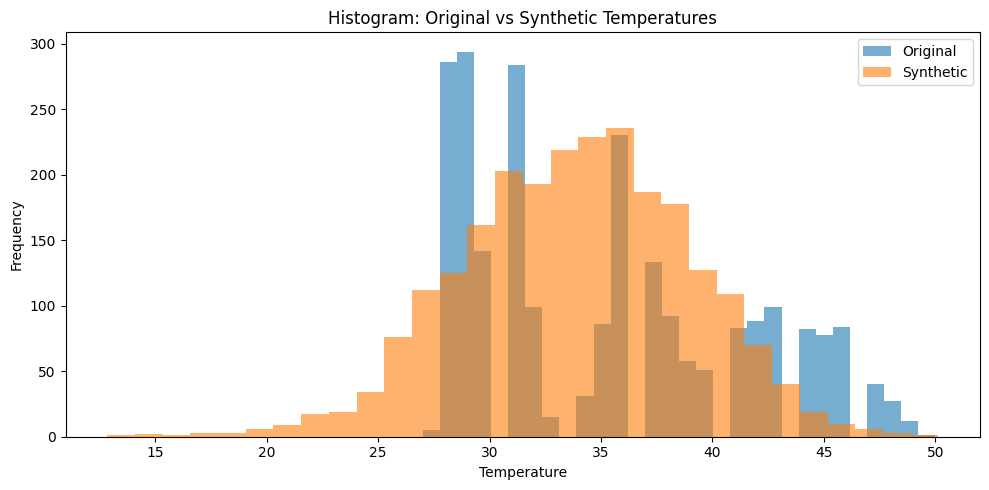

In [16]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import numpy as np

# Load and prepare the data
df = pd.read_csv("temperature.csv", parse_dates=["datetime"])
df.rename(columns={"datetime": "ds", "temp": "y"}, inplace=True)
df = df.sort_values("ds")
df['unique_id'] = 'sensor_1'
df = df.dropna()

# Normalize the target variable
scaler = StandardScaler()
df['y_scaled'] = scaler.fit_transform(df[['y']])

# Build sequences
sequence_length = 24
X = [df['y_scaled'].values[i:i+sequence_length] for i in range(len(df)-sequence_length)]
X = torch.tensor(X, dtype=torch.float32)

# Define VAE
class VAE(nn.Module):
    def __init__(self, input_dim=24, latent_dim=8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16), nn.ReLU(),
            nn.Linear(16, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16), nn.ReLU(),
            nn.Linear(16, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

# Train VAE
vae = VAE()
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
loader = DataLoader(TensorDataset(X), batch_size=32, shuffle=True)

for epoch in range(10):
    for batch in loader:
        x_batch = batch[0]
        x_recon = vae(x_batch)
        loss = loss_fn(x_recon, x_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Generate synthetic data
with torch.no_grad():
    z = torch.randn(100, 8)  # 100 sequences
    synthetic = vae.decoder(z).numpy()

# Flatten and denormalize
synthetic_flat = synthetic.flatten().reshape(-1, 1)
synthetic_denorm = scaler.inverse_transform(synthetic_flat).flatten()

# Save to CSV
synthetic_df = pd.DataFrame({
    'synthetic_temp': synthetic_denorm
})
synthetic_df.to_csv('synthetic_temperature.csv', index=False)

# Evaluation
original_sample = df['y'].values[:len(synthetic_denorm)]
print(f"Original Mean: {original_sample.mean():.2f}, Std: {original_sample.std():.2f}")
print(f"Synthetic Mean: {synthetic_denorm.mean():.2f}, Std: {synthetic_denorm.std():.2f}")

ks_stat, ks_p = ks_2samp(original_sample, synthetic_denorm)
print(f"KS Statistic: {ks_stat:.4f}, p-value: {ks_p:.4f}")

# Plot comparison
plt.figure(figsize=(10,5))
plt.hist(original_sample, bins=30, alpha=0.6, label='Original')
plt.hist(synthetic_denorm, bins=30, alpha=0.6, label='Synthetic')
plt.title("Histogram: Original vs Synthetic Temperatures")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

This still gave me data that was off. I am increasing torch.randn(100,8). to 500. A higher number might give an even better result but I am using a CPU so I do not want to cause it to timeout by running to heavy a task

Original Mean: 31.00, Std: 4.17
Synthetic Mean: 34.43, Std: 5.27
KS Statistic: 0.5115, p-value: 0.0000


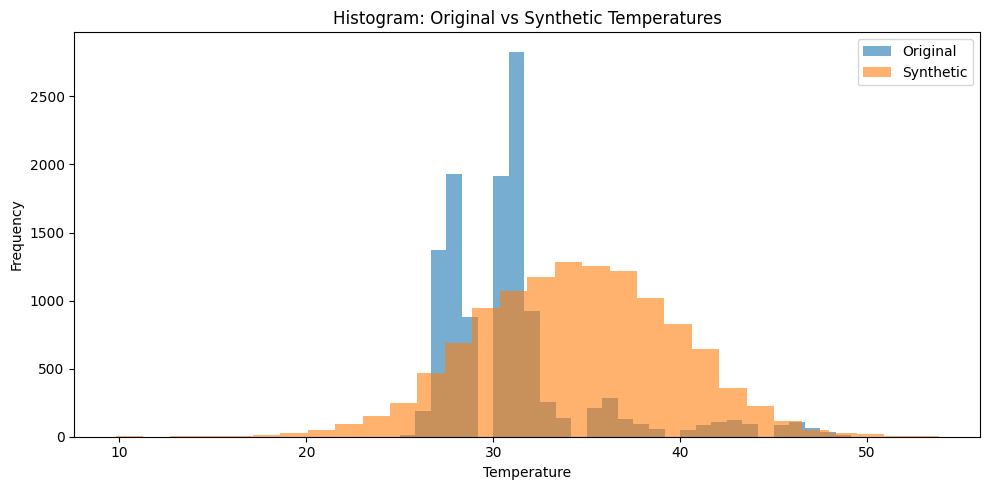

In [19]:
# Generate synthetic data
with torch.no_grad():
    z = torch.randn(500, 8)  # 500 sequences
    synthetic = vae.decoder(z).numpy()

# Flatten and denormalize
synthetic_flat = synthetic.flatten().reshape(-1, 1)
synthetic_denorm = scaler.inverse_transform(synthetic_flat).flatten()

# Save to CSV
synthetic_df = pd.DataFrame({
    'synthetic_temp': synthetic_denorm
})
synthetic_df.to_csv('synthetic_temperature.csv', index=False)

# Evaluation
original_sample = df['y'].values[:len(synthetic_denorm)]
print(f"Original Mean: {original_sample.mean():.2f}, Std: {original_sample.std():.2f}")
print(f"Synthetic Mean: {synthetic_denorm.mean():.2f}, Std: {synthetic_denorm.std():.2f}")

ks_stat, ks_p = ks_2samp(original_sample, synthetic_denorm)
print(f"KS Statistic: {ks_stat:.4f}, p-value: {ks_p:.4f}")

# Plot comparison
plt.figure(figsize=(10,5))
plt.hist(original_sample, bins=30, alpha=0.6, label='Original')
plt.hist(synthetic_denorm, bins=30, alpha=0.6, label='Synthetic')
plt.title("Histogram: Original vs Synthetic Temperatures")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

This is still off. In troubleshooting, it may be due to scaling issues. One last try

Original Mean: 35.05, Std: 5.70
Synthetic Mean: 32.80, Std: 8.68
KS Statistic: 0.2283, p-value: 0.0000


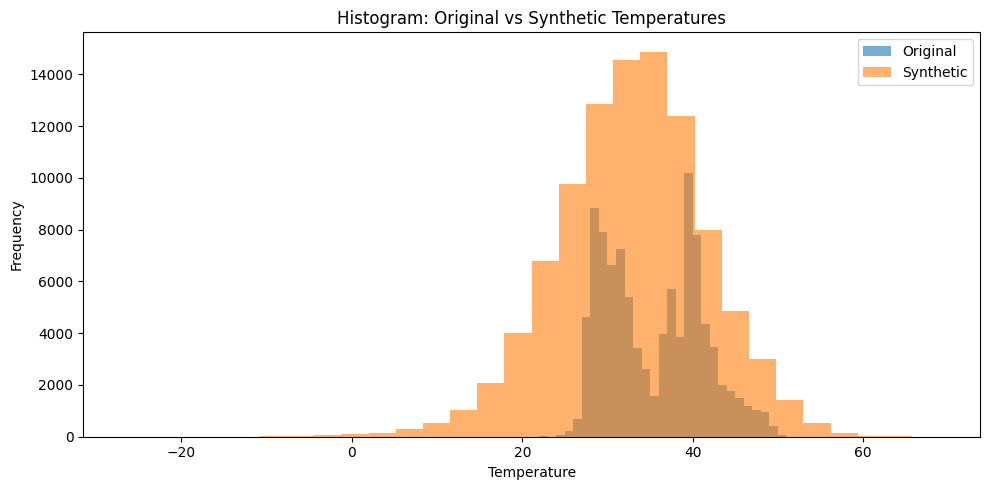

In [27]:
# Load and prepare the data
df = pd.read_csv("temperature.csv", parse_dates=["datetime"])
df.rename(columns={"datetime": "ds", "temp": "y"}, inplace=True)
df = df.sort_values("ds")
df['unique_id'] = 'sensor_1'
df = df.dropna()

# Normalize the target variable
scaler = StandardScaler()
df['y_scaled'] = scaler.fit_transform(df[['y']])

# Build sequences
sequence_length = 24
X = [df['y_scaled'].values[i:i+sequence_length] for i in range(len(df)-sequence_length)]
X = torch.tensor(X, dtype=torch.float32)

# Define VAE
class VAE(nn.Module):
    def __init__(self, input_dim=24, latent_dim=8):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16), nn.ReLU(),
            nn.Linear(16, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16), nn.ReLU(),
            nn.Linear(16, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

# Train VAE
vae = VAE()
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
loader = DataLoader(TensorDataset(X), batch_size=32, shuffle=True)

for epoch in range(50): #changing from 10 to 50
    for batch in loader:
        x_batch = batch[0]
        x_recon = vae(x_batch)
        loss = loss_fn(x_recon, x_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Generate synthetic data
n_samples = len(df['y']) // 24
with torch.no_grad():
    z = torch.randn(n_samples, 8)  # keeping this change at 500
    synthetic = vae.decoder(z).numpy()

# Flatten and denormalize
synthetic_flat = synthetic.flatten().reshape(-1, 1)
synthetic_denorm = scaler.inverse_transform(synthetic_flat).flatten()

# Save to CSV
synthetic_df = pd.DataFrame({
    'synthetic_temp': synthetic_denorm
})
synthetic_df.to_csv('synthetic_temperature.csv', index=False)

# Evaluation
original_sample = df['y'].values #changing this so it is the full original series
print(f"Original Mean: {original_sample.mean():.2f}, Std: {original_sample.std():.2f}")
print(f"Synthetic Mean: {synthetic_denorm.mean():.2f}, Std: {synthetic_denorm.std():.2f}")

ks_stat, ks_p = ks_2samp(original_sample, synthetic_denorm)
print(f"KS Statistic: {ks_stat:.4f}, p-value: {ks_p:.4f}")

# Plot comparison
plt.figure(figsize=(10,5))
plt.hist(original_sample, bins=30, alpha=0.6, label='Original')
plt.hist(synthetic_denorm, bins=30, alpha=0.6, label='Synthetic')
plt.title("Histogram: Original vs Synthetic Temperatures")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

Above, I matched the original shape of the original data rather than generating less data. It is a closer match but still not statistically similar because of the difference in the distribution. Suggestions from AI tools suggest it is an issue with the model, so I will try one last time below

Epoch 1, Loss: 0.9707
Epoch 2, Loss: 0.9234
Epoch 3, Loss: 0.9197
Epoch 4, Loss: 0.9216
Epoch 5, Loss: 0.9201
Epoch 6, Loss: 0.9197
Epoch 7, Loss: 0.9206
Epoch 8, Loss: 0.9245
Epoch 9, Loss: 0.9216
Epoch 10, Loss: 0.9222
Epoch 11, Loss: 0.9207
Epoch 12, Loss: 0.9212
Epoch 13, Loss: 0.9230
Epoch 14, Loss: 0.9181
Epoch 15, Loss: 0.9183
Epoch 16, Loss: 0.9166
Epoch 17, Loss: 0.9233
Epoch 18, Loss: 0.9204
Epoch 19, Loss: 0.9200
Epoch 20, Loss: 0.9198
Epoch 21, Loss: 0.9189
Epoch 22, Loss: 0.9190
Epoch 23, Loss: 0.9245
Epoch 24, Loss: 0.9215
Epoch 25, Loss: 0.9189
Epoch 26, Loss: 0.9188
Epoch 27, Loss: 0.9215
Epoch 28, Loss: 0.9191
Epoch 29, Loss: 0.9182
Epoch 30, Loss: 0.9215
Epoch 31, Loss: 0.9220
Epoch 32, Loss: 0.9217
Epoch 33, Loss: 0.9205
Epoch 34, Loss: 0.9195
Epoch 35, Loss: 0.9178
Epoch 36, Loss: 0.9183
Epoch 37, Loss: 0.9169
Epoch 38, Loss: 0.9218
Epoch 39, Loss: 0.9184
Epoch 40, Loss: 0.9194
Epoch 41, Loss: 0.9223
Epoch 42, Loss: 0.9216
Epoch 43, Loss: 0.9208
Epoch 44, Loss: 0.92

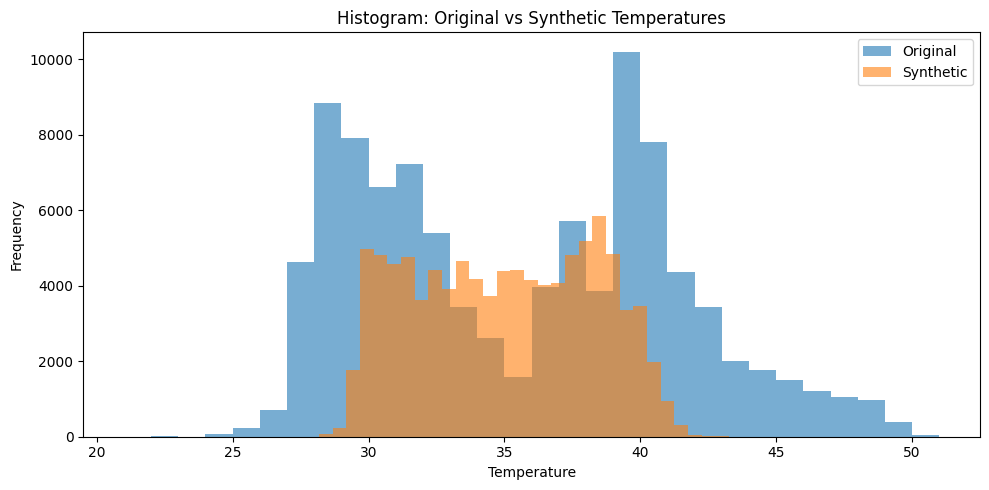

In [32]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt

# Load and prepare the data
df = pd.read_csv("temperature.csv", parse_dates=["datetime"])
df.rename(columns={"datetime": "ds", "temp": "y"}, inplace=True)
df = df.sort_values("ds")
df['unique_id'] = 'sensor_1'
df = df.dropna()

# Normalize the target variable
scaler = StandardScaler()
df['y_scaled'] = scaler.fit_transform(df[['y']])

# Build sequences (24-hour windows)
sequence_length = 24
X = [df['y_scaled'].values[i:i+sequence_length] for i in range(len(df) - sequence_length)]
X = torch.tensor(X, dtype=torch.float32)

# Define the Variational Autoencoder
class VAE(nn.Module):
    def __init__(self, input_dim=24, latent_dim=8):
        super().__init__()
        # Encoder
        self.encoder_fc1 = nn.Linear(input_dim, 16)
        self.encoder_fc2_mu = nn.Linear(16, latent_dim)
        self.encoder_fc2_logvar = nn.Linear(16, latent_dim)
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim)
        )

    def encode(self, x):
        h = torch.relu(self.encoder_fc1(x))
        mu = self.encoder_fc2_mu(h)
        logvar = self.encoder_fc2_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

# Training setup
vae = VAE()
optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
loader = DataLoader(TensorDataset(X), batch_size=32, shuffle=True)

def kl_divergence(mu, logvar):
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()

# Train the VAE
for epoch in range(50):
    vae.train()
    epoch_loss = 0
    for batch in loader:
        x_batch = batch[0]
        x_recon, mu, logvar = vae(x_batch)
        recon_loss = loss_fn(x_recon, x_batch)
        kl_loss = kl_divergence(mu, logvar)
        loss = recon_loss + kl_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {epoch_loss / len(loader):.4f}")

# Generate synthetic sequences
n_samples = len(df['y']) // sequence_length
with torch.no_grad():
    z = torch.randn(n_samples, 8)  # Now valid due to KL regularization
    synthetic = vae.decode(z).numpy()

# Flatten and denormalize
synthetic_flat = synthetic.flatten().reshape(-1, 1)
synthetic_denorm = scaler.inverse_transform(synthetic_flat).flatten()
synthetic_denorm = synthetic_denorm[:len(df['y'])]  # Clip to match original length

# Save synthetic data
synthetic_df = pd.DataFrame({'synthetic_temp': synthetic_denorm})
synthetic_df.to_csv("synthetic_temperature.csv", index=False)

# Evaluation
original_sample = df['y'].values
print(f"Original Mean: {original_sample.mean():.2f}, Std: {original_sample.std():.2f}")
print(f"Synthetic Mean: {synthetic_denorm.mean():.2f}, Std: {synthetic_denorm.std():.2f}")

ks_stat, ks_p = ks_2samp(original_sample, synthetic_denorm)
print(f"KS Statistic: {ks_stat:.4f}, p-value: {ks_p:.4f}")

# Plot histogram comparison
plt.figure(figsize=(10, 5))
plt.hist(original_sample, bins=30, alpha=0.6, label='Original')
plt.hist(synthetic_denorm, bins=30, alpha=0.6, label='Synthetic')
plt.title("Histogram: Original vs Synthetic Temperatures")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

This is a closer match to the original mean but still off. I feel this is a good place for me to stop for now, with room for improving the model later.